# Applications of Regression

## Overview

In this lab you will apply regression to some realistic data. In this lab you will work with the automotive price dataset. Your goal is to construct a linear regression model to predict the price of automobiles from their characteristics. 

In this lab will learn to:

1. Use categorical data with Scikit-Learn. 
2. Apply transformations to features and labels to improve model performance. 
3. Compare regression models to improve model performance. 

## Load the dataset

As a first, step you will load the dataset into the notebook environment. 

First, execute the code in the cell below to load  the packages you will need to run the rest of this notebook. 

In [13]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(caret)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

The code in the cell below loads the dataset which was prepared in a previous lab. Execute this code and ensure that the expected columns are present. 

In [14]:
auto_prices = read.csv('Auto_Prices_Preped.csv')
names(auto_prices)

[1] "X"                 "symboling"         "normalized.losses"
 [4] "make"              "fuel.type"         "aspiration"       
 [7] "num.of.doors"      "body.style"        "drive.wheels"     
[10] "engine.location"   "wheel.base"        "length"           
[13] "width"             "height"            "curb.weight"      
[16] "engine.type"       "num.of.cylinders"  "engine.size"      
[19] "fuel.system"       "bore"              "stroke"           
[22] "compression.ratio" "horsepower"        "peak.rpm"         
[25] "city.mpg"          "highway.mpg"       "price"            
[28] "log_price"

Notice that both the label, `price` and the logrithmically transformed versions are included. 

As a next step, execute the code in the cell below to display and examine the first few rows of the dataset. 

In [15]:
head(auto_prices)

X,symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,...,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price,log_price
1,3,?,alfa-romero,gas,std,two,hardtop_convert,rwd,front,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495,9.510075
2,3,?,alfa-romero,gas,std,two,hardtop_convert,rwd,front,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500,9.711116
3,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500,9.711116
4,2,164,audi,gas,std,four,sedan,fwd,front,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950,9.543235
5,2,164,audi,gas,std,four,sedan,4wd,front,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450,9.767095
6,2,?,audi,gas,std,two,sedan,fwd,front,...,mpfi,3.19,3.40,8.5,110,5500,19,25,15250,9.632335


Notice that there are both numeric and categorical features. 

## Split the dataset

You must now create randomly sampled training and test data sets. The `createDataPartition` function from the R caret package is used  to create indices for the training data sample. In this case 75% of the data will be used  for training the model. Since this data set is small only 48 cases will be included in the test dataset. Execute this code and note the dimensions of the resulting data frame. 

In [16]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(auto_prices[,'fuel.type'], times = 1, p = 0.75, list = FALSE)
training = auto_prices[partition,] # Create the training sample
dim(training)
test = auto_prices[-partition,] # Create the test sample
dim(test)

[1] 147  28

[1] 48 28

## Scale numeric features

Numeric features must be rescaled so they have a similar range of values. Rescaling prevents features from having an undue influence on model training simply because then have a larger range of numeric variables. 

The code in the cell below uses the `preProcess` function from the caret function. The processing is as follows:
1. The preprocessing model object is computed. In this case the processing includes centering and scaling the numeric feature. Notice that this model is fit only ot the training data.
2. The scalling is appled both the test and training partitions.

Execute the code. 

In [17]:
num_cols = c('curb.weight', 'horsepower', 'city.mpg')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,curb.weight,horsepower,city.mpg
1,-0.07121387,0.1417937,-0.6352759
2,-0.07121387,0.1417937,-0.6352759
6,-0.14739526,0.1160607,-0.9389687
7,0.47877864,0.1160607,-0.9389687
8,0.68316774,0.1160607,-0.9389687
9,0.92843467,0.8880485,-1.2426616


These three numeric features are now scaled. 

## Construct the linear regression model

With data prepared and split into training and test subsets, you will now compute the linear regression model. There are 28 features, so the model will require at least 28 coefficients. The equation for such a **multiple regression** problem can be writen as:

$$\hat{y} = f(\vec{x}) = \vec{\beta} \cdot \vec{x} + b\\ = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n + b$$  
where;  
$\hat{y}$ are the predicted values or scores,   
$\vec{x}$ is the vector of feature values with components $\{ x_1, x_2, \cdots, x_n$,  
$\vec{\beta}$ is vector of model coefficients with components $\{ \beta_1, \beta_2, \cdots, \beta_n$,  
$b$ is the intercept term, if there is one.

You can think of the linear regression function $f(\vec{x})$ as the dot product between the beta vector $\vec{\beta}$ and the feature vector $\vec{x}$, plus the intercecpt term $b$.

In R models are defined by an equation using the $\sim$ symbol to mean modeled by. In summary, the variable to be modeled is always on the left. The features are listed on the right. This basic scheme can be written as shown here. 

$$label \sim features$$

Categorical and numerical features can be combined in the model formula. Features not specified in the formula are ignored.

The code in the cell below uses the R `lm` function to compute the model coefficients and create a model object.  Execute this code. 

In [18]:
## define and fit the linear regression model
lin_mod = lm(log_price ~ curb.weight + horsepower + city.mpg + fuel.type + aspiration +
             body.style + drive.wheels + num.of.cylinders, data = training)

The model has been fit to the traning data. Execute the code in the cell below to examine the value of the intercept term and coefficients. 

In [19]:
summary(lin_mod)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),9.838118246,0.17689877,55.61439496,1.877120e-94
curb.weight,0.186412296,0.04507548,4.13555920,6.212131e-05
horsepower,0.123147071,0.03872793,3.17980023,1.830948e-03
city.mpg,-0.100148774,0.03722663,-2.69024555,8.048728e-03
fuel.typegas,-0.212743286,0.08775702,-2.42423105,1.667438e-02
aspirationturbo,-0.009604352,0.05277158,-0.18199857,8.558589e-01
body.stylehatchback,-0.147475507,0.06416581,-2.29835010,2.309004e-02
body.stylesedan,-0.069378678,0.06124729,-1.13276317,2.593365e-01
body.stylewagon,-0.151977319,0.07726665,-1.96692003,5.125848e-02
drive.wheelsfwd,-0.007944480,0.11076764,-0.07172203,9.429301e-01


You can interpret these coefficients as follows:
1. The intercept is the mean of the (log) price with respect to the (scaled) features. 
2. The coefficients numeric features are the change in the (log) price for a unit change in the (scaled) feature.
3. The coefficients of the categorical features are a bit harder to understand. R uses a technique known at the **method of contrasts**. The intercept is computed using one, arbitrarily chosen, category. The coefficients for other categories are the differences, or contrasts, with the intercept term for each category. 

## Evaluate the model

You will now use the test dataset to evaluate the performance of the regression model. As a first step, execute the code in the cell below to compute and display various performance metrics and examine the results. 

In [20]:
print_metrics = function(lin_mod, df, score, label){
    resids = df[,label] - score
    resids2 = resids**2
    N = length(score)
    r2 = as.character(round(summary(lin_mod)$r.squared, 4))
    adj_r2 = as.character(round(summary(lin_mod)$adj.r.squared, 4))
    cat(paste('Mean Square Error      = ', as.character(round(sum(resids2)/N, 4)), '\n'))
    cat(paste('Root Mean Square Error = ', as.character(round(sqrt(sum(resids2)/N), 4)), '\n'))
    cat(paste('Mean Absolute Error    = ', as.character(round(sum(abs(resids))/N, 4)), '\n'))
    cat(paste('Median Absolute Error  = ', as.character(round(median(abs(resids)), 4)), '\n'))
    cat(paste('R^2                    = ', r2, '\n'))
    cat(paste('Adjusted R^2           = ', adj_r2, '\n'))
}

score = predict(lin_mod, newdata = test)
print_metrics(lin_mod, test, score, label = 'log_price')      

Mean Square Error      =  0.0197 
Root Mean Square Error =  0.1403 
Mean Absolute Error    =  0.105 
Median Absolute Error  =  0.0751 
R^2                    =  0.8877 
Adjusted R^2           =  0.8776 


At first glance, these metrics look promising. The RMSE, MAE and median absolute error are all small and in a similar range. However, notice that the $R^2$ and $R^2_{adj}$ are somewhat different. This model has a large number of parameters compared to the number of cases available. This result indicates that the model may be over-fit and might not generalize well. 

To continue the evaluation of the model performance, execute the code in the cell below to display a histogram of the residuals. 

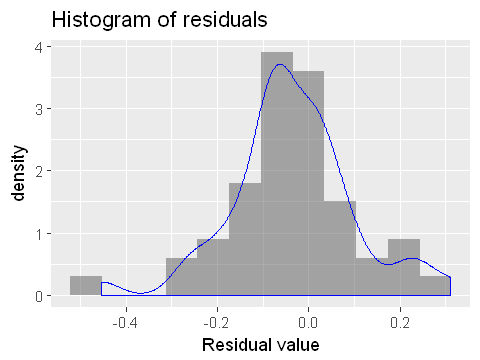

In [21]:
hist_resids = function(df, score, label, bins = 10){
    options(repr.plot.width=4, repr.plot.height=3) # Set the initial plot area dimensions
    df$resids = df[,label] - score
    bw = (max(df$resids) - min(df$resids))/(bins + 1)
    ggplot(df, aes(resids)) + 
       geom_histogram(binwidth = bw, aes(y=..density..), alpha = 0.5) +
       geom_density(aes(y=..density..), color = 'blue') +
       xlab('Residual value') + ggtitle('Histogram of residuals')
}

hist_resids(test, score, label = 'log_price')   

This histogram shows that the residuals are in a small range. However, there is some noticeable skew in the distribution, including an outlier. 

Next, execute the code in the cell below to display the Q-Q Normal plot. 

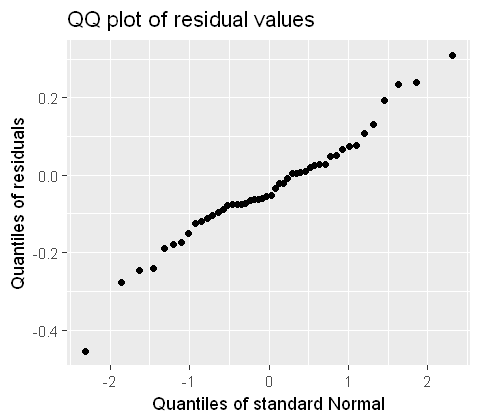

In [22]:
resids_qq = function(df, score, label){
    options(repr.plot.width=4, repr.plot.height=3.5) # Set the initial plot area dimensions
    df$resids = df[,label] - score
    ggplot() + 
    geom_qq(data = df, aes(sample = resids)) + 
    ylab('Quantiles of residuals') + xlab('Quantiles of standard Normal') +
    ggtitle('QQ plot of residual values')
}

resids_qq(test, score, label = 'log_price') 

As with the histogram, the Q-Q Normal plot indicates the residuals are close to Normally distributed, show some skew (deviation from the stright line). This is particularly for large positive residuls. 

There is one more diagnostic plot. Execute the code in the cell below to dislplay the plot of residuals vs. predicted values. 

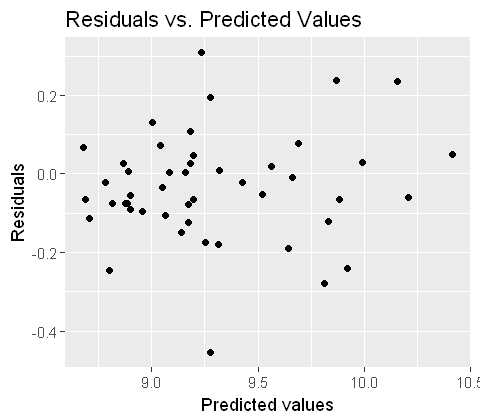

In [23]:
resid_plot = function(df, score, label){
    df$score = score
    df$resids = df[,label] - score
    ggplot(df, aes(score, resids)) + 
    geom_point() + 
    ggtitle('Residuals vs. Predicted Values') +
    xlab('Predicted values') + ylab('Residuals')
}

resid_plot(test, score, label = 'log_price')

This plot looks reasonable. The residual values appear to have a fairly constant dispursion as the predicted value changes. A few large residuals are noticable, particularly on the positive side.

But, wait! This residual plot is for the log of the auto price. What does the plot look like when transformed to real prices? Execute the code in the cell below to find out. 

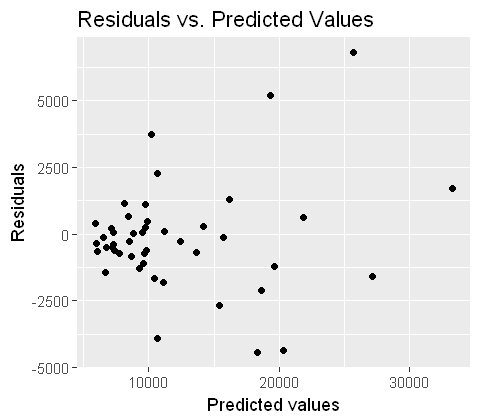

In [24]:
score_untransform = exp(score)
resid_plot(test, score_untransform, label = 'price')

Notice that the untransformed residuals show a definite trend. The dispursion of the residuals has a cone-like pattern increasing to the right. The regression model seems to do a good job of predicting the price of low cost cars, but becomes progressively worse as the price of the car increases. 

## Summary

In this lesson you have done the following in the process of constructing and evaluating a multiple linear regression model:   
1. Transformed the label value to make it more symmetric and closer to a Normal distribution.
2. Aggregated categories of a categorical variable to improve the statistical representation. 
3. Scaled the numeric features. 
4. Recoded the categorical features as binary dummy variables. 
5. Fit the linear regression model using the `lm` function. 
6. Evaluated the performance of the model using both numeric and graphical methods. 

It is clear from the outcome of the performance evaluation that this model needs to be improved. As it is, the model shows poor generalizatiion. 